# Použité knihovny

In [1]:
import numpy as np
import soundfile as sf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as sig

# Použité materiály nad rámec standardních materiálů
[https://www.fit.vutbr.cz/~grezl/ZRE/lectures/05_pitch_en.pdf](https://www.fit.vutbr.cz/~grezl/ZRE/lectures/05_pitch_en.pdf)

[https://numpy.org/doc/stable/reference/](https://numpy.org/doc/stable/reference/)

[https://pandas.pydata.org/docs/reference/index.html](https://pandas.pydata.org/docs/reference/index.html)

[https://docs.scipy.org/doc/scipy/](https://docs.scipy.org/doc/scipy/)

[https://matplotlib.org/stable/index.html](https://matplotlib.org/stable/index.html)

[https://en.wikipedia.org/wiki/Cent_(music)](https://en.wikipedia.org/wiki/Cent_(music))

[https://en.wikipedia.org/wiki/Envelope_(music)](https://en.wikipedia.org/wiki/Envelope_(music))

[https://www.edmprod.com/adsr-envelopes/](https://www.edmprod.com/adsr-envelopes/)

# Základy
## Načtení tónů
Následující kód je přímo nezměněný ze zadání (bez importů). Provede načtení 0.5s dlouhého úseku z každého tónu (s přeskočením prvních 0.25s, aby nebyl slyšet úder kladívka). 

In [2]:
MIDIFROM = 24
MIDITO = 108
SKIP_SEC = 0.25
HOWMUCH_SEC = 0.5
WHOLETONE_SEC = 2
howmanytones = MIDITO - MIDIFROM + 1
tones = np.arange(MIDIFROM, MIDITO+1)
s, Fs = sf.read('../klavir.wav')
N = int(Fs * HOWMUCH_SEC)
Nwholetone = int(Fs * WHOLETONE_SEC)
xall = np.zeros((MIDITO+1, N)) 
samplefrom = int(SKIP_SEC * Fs)
sampleto = samplefrom + N
for tone in tones:
    x = s[samplefrom:sampleto]
    x = x - np.mean(x)
    xall[tone, :] = x
    samplefrom += Nwholetone
    sampleto += Nwholetone

## Načtení `midi.txt`
Následující kód čte a parsuje soubor `midi.txt` (obsahující tóny a odpovídající frekvence) pomocí knihovny Pandas. Soubor se naparsuje jako CSV s oddělovačem tab. Midi tón se použije pro indexování.

In [3]:
midi = pd.read_csv('midi.txt', sep='\t', header=None, index_col=0, names=['midi', 'freq'])

## Načtení `xkucha28.txt`
Následující kód čte a parsuje soubor `xkucha28.txt` (obsahující přidělené midi tóny). Jednotlivé tóny se načtou, převedou na číslo a z minulého kroku se zjistí základní frekvence. Tóny s frekvencí jsou uloženy v poli jako tuple

In [4]:
xkucha28 = list(map(int, open('xkucha28.txt', 'r').read().strip().split(' ')))
xkucha28t = [(x, midi['freq'][x]) for x in xkucha28]
xkucha28t

[(39, 77.78), (54, 185.0), (101, 2793.83)]

## Zobrazení 3 period
Pro každou frekvenci vypočítám délku 3 period a následně tento úsek zobrazím.

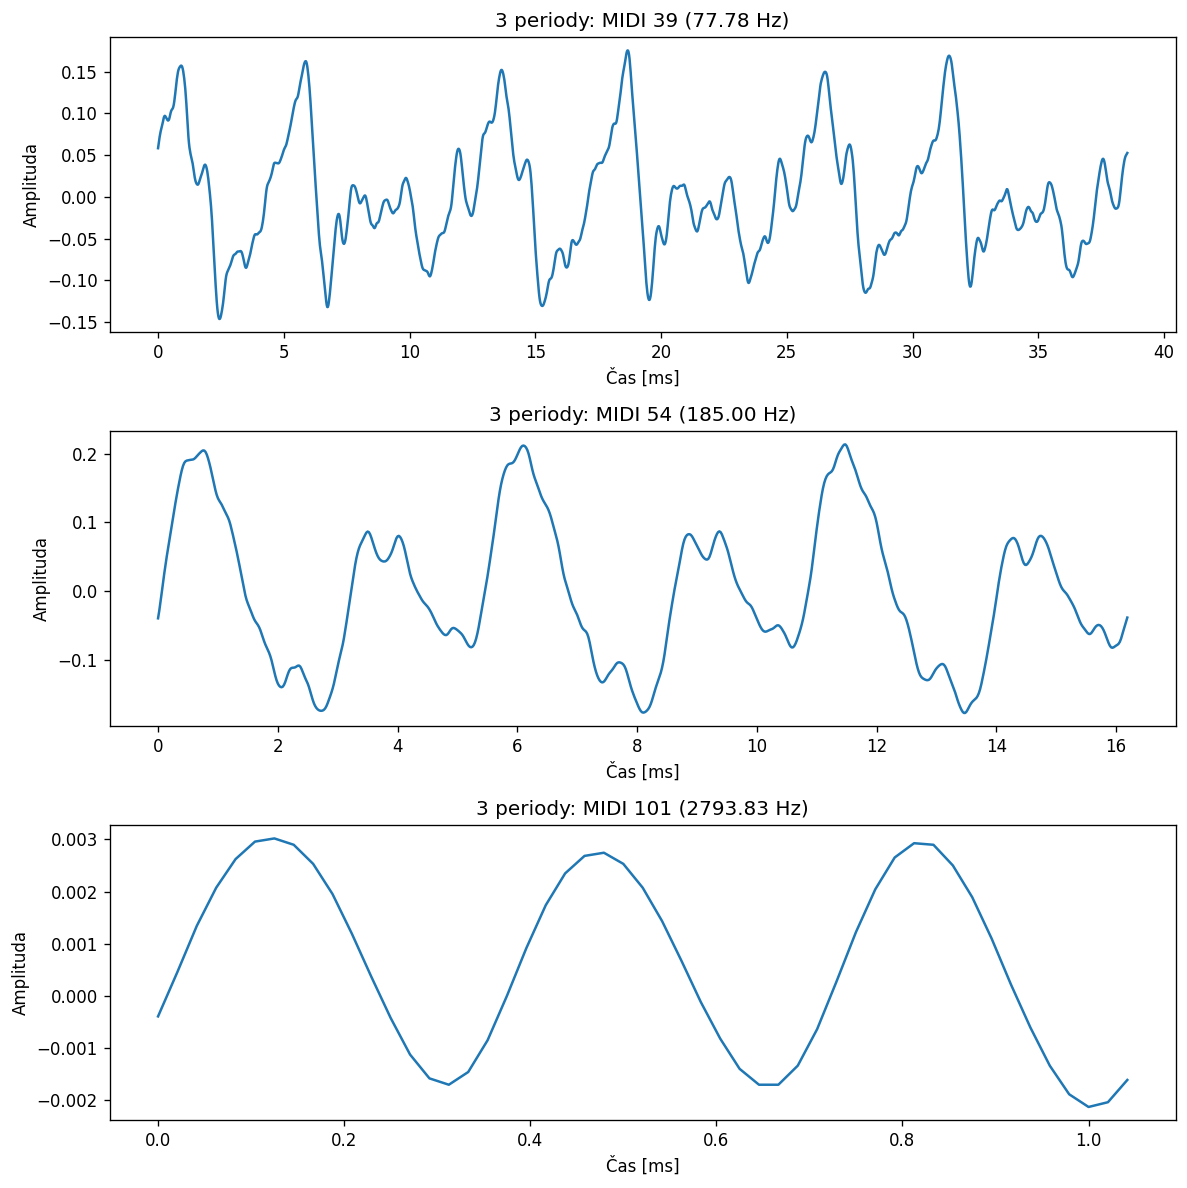

In [5]:
plt.figure(figsize=(10, 10), dpi=120)
for i, (tone, freq) in enumerate(xkucha28t):
    three_periods = int(Fs / freq * 3)
    plt.subplot(3, 1, i+1)
    plt.plot(1000 * np.arange(0, three_periods) / Fs, xall[tone, :three_periods])
    plt.title(f"3 periody: MIDI {tone} ({freq:.2f} Hz)")
    plt.xlabel("Čas [ms]")
    plt.ylabel("Amplituda")
plt.tight_layout()


## Spočítání a zobrazení DFT
Pomocí numpy spočítám DFT pro zadané signály. K signálu jsem podle zadání pryčetl konstantu $10^{-5}$, aby se dalo spektrum pěkně zobrazit.

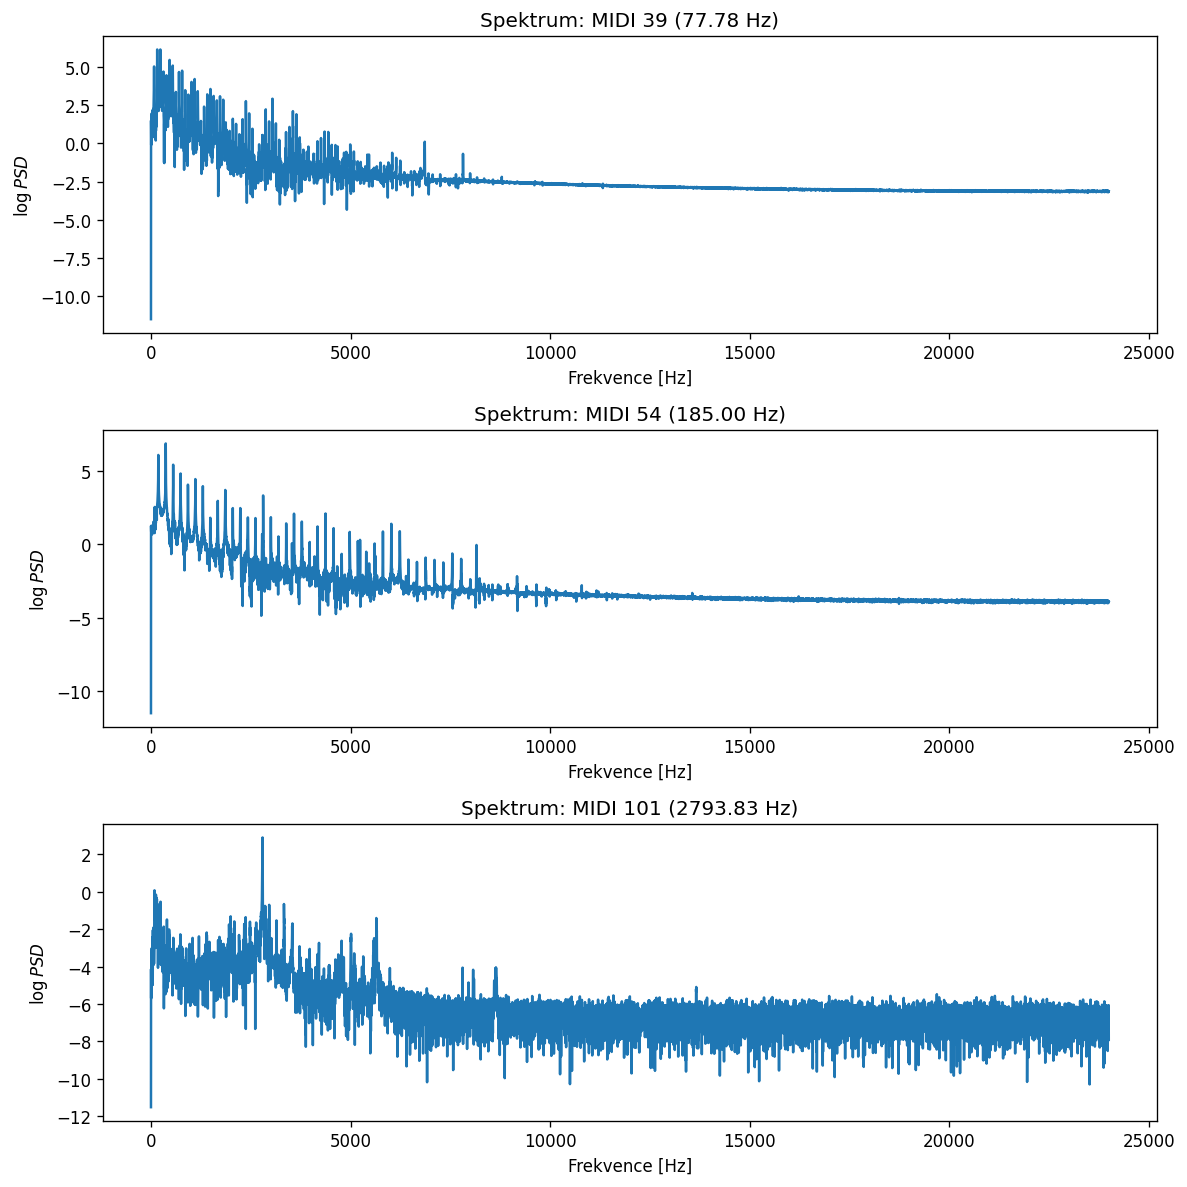

In [6]:
plt.figure(figsize=(10, 10), dpi=120)
for i, (tone, freq) in enumerate(xkucha28t):
    fft = np.log(np.abs(np.fft.fft(xall[tone]) + 1e-5))
    plt.subplot(3, 1, i+1)
    plt.plot(np.arange(0, Fs / 2, 2), fft[:len(fft)//2])
    plt.title(f"Spektrum: MIDI {tone} ({freq:.2f} Hz)")
    plt.xlabel("Frekvence [Hz]")
    plt.ylabel("$\log PSD$")
plt.tight_layout()


## Uložení tónů
Pomocí knihovny soundfile uložím původní tóny.

In [7]:
names = ['a', 'b', 'c']
for i, tone in enumerate(xkucha28):
    sf.write(f'../audio/{names[i]}_orig.wav', xall[tone], Fs)

# Určení základní frekvence
Pro určení základní frekvence pro každý tón jsem použil dvě metody. Pro frekvence do 800Hz jsem použil autokorelaci a pro frekvence nad 800Hz jsem použil DFT. Jak zadání napovídá, tak autokorelace selhávala při vyšších frekvencích (vycházela například poloviční frekvence). Hranici 800Hz jsem zjistil experimentálně. Vzorec pro kalkulaci základní frekvence při využití autokorelace: 
$$f_0 = \frac{F_S}{L}$$

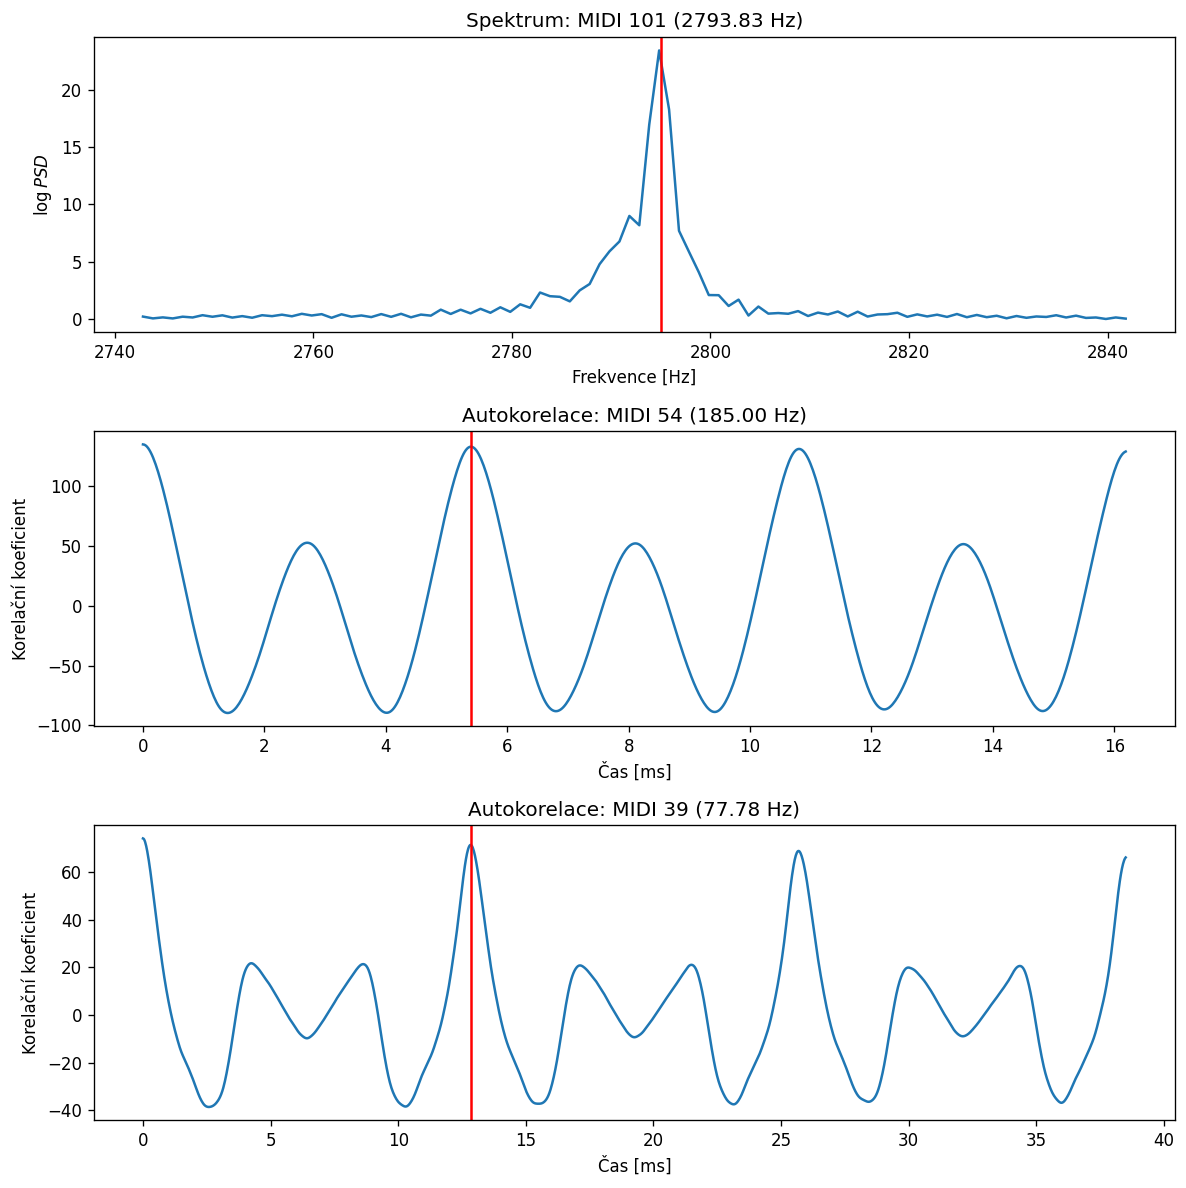

In [8]:
data = []
estimates = np.zeros(MIDITO + 1)
i = 1
plt.figure(figsize=(10, 10), dpi=120)
for tone, freq in midi.iterrows():
    f = 0
    if freq['freq'] < 800:
        c = sig.correlate(xall[tone], xall[tone], mode='full')
        c = c[len(c)//2:]
        d = np.diff(c)
        start = np.nonzero(d > 0)[0][0]
        peak = np.argmax(c[start:]) + start
        f = Fs / peak
        if tone in xkucha28:
            plt.subplot(3, 1, i)
            plt.plot(np.linspace(0, 1000 * peak * 3 / Fs, peak*3), c[:peak*3])
            plt.title(f"Autokorelace: MIDI {tone} ({freq['freq']:.2f} Hz)")
            plt.xlabel("Čas [ms]")
            plt.ylabel("Korelační koeficient")
            plt.axvline(1000 * peak / Fs, color='red')
            i += 1
    else:
        fft = np.abs(np.fft.fft(xall[tone], Fs))
        fft = fft[:len(fft)//2]
        f = np.argmax(fft)
        if tone in xkucha28:
            offset = 50
            space = np.arange(freq['freq'] - offset - 1, freq['freq'] + offset - 1)
            plt.subplot(3, 1, i)
            plt.plot(space, fft[int(freq['freq']) - offset:int(freq['freq'] + offset)])
            plt.title(f"Spektrum: MIDI {tone} ({freq['freq']:.2f} Hz)")
            plt.xlabel("Frekvence [Hz]")
            plt.ylabel("$\log PSD$")
            plt.axvline(f, color='red')
            i += 1
    data.append([f, freq['freq'], 100 * abs(f - freq['freq']) / freq['freq']])
    estimates[tone] = f
est_stats = pd.DataFrame(data=data, columns=['Calculated', 'Expected', 'Error %'])
plt.tight_layout()

## Chyba při prvotním určení frekvence
Zde je tabulka se statistikou chyby napříč všemi frekvencemi. Dle mého je prvotní odhad frekvence velice slušný (Průměrná chyba 0.2%, maximální chyba 0.5%). Primární chyba vzniká kvůli rozlišení DFT/autokorelace. U DFT v následujícím kroku odhad zlepším, u autokorelace by se dala použít interpolace.

In [9]:
est_stats['Error %'].describe()

count    85.000000
mean      0.209296
std       0.148492
min       0.023285
25%       0.065841
50%       0.195465
75%       0.334238
max       0.544617
Name: Error %, dtype: float64

# Zpřesnění odhadu základní frekvence $f_0$
Pro zpřesnění odhadu základní frekvence jsem používám DTFT. Počítám 100 centů kolem MIDI frekvence. Frekvence do 100Hz jsem nezpřesňoval, protože se to neukázalo jako funkční řešení a akorát to zhoršovalo původní odhad pomocí autokorelace.

In [10]:
data = []
hundred_cent = 2**(100/1200)
for tone, freq in midi.iterrows(): 
    if freq['freq'] < 100:
        f = estimates[tone]
        data.append([f, freq['freq'], 100 * abs(f - freq['freq']) / freq['freq']])
        continue
    FREQPOINTS = 500
    N = int(Fs / 2)
    n = np.arange(0, N)
    start = freq['freq'] / hundred_cent
    end = freq['freq'] * hundred_cent
    fsweep = np.linspace(start, end, FREQPOINTS)
    A = np.zeros([FREQPOINTS, N], dtype=complex)
    for k in np.arange(0, FREQPOINTS):
        A[k, :] = np.exp(-1j * 2 * np.pi * fsweep[k] / Fs * n)
    Xdtft = np.matmul(A, xall[tone].T)
    f = fsweep[np.argmax(np.abs(Xdtft))]
    estimates[tone] = f
    data.append([f, freq['freq'], 100 * abs(f - freq['freq']) / freq['freq']])
est_stats2 = pd.DataFrame(data=data, columns=['Calculated', 'Expected', 'Error %'])


## Chyba po zlepšení odhadu základní frekvence
Po zlepšení odhadu základní frekvence se průměrná chyba výrazně snížila.

In [11]:
est_stats2['Error %'].describe()

count    85.000000
mean      0.138748
std       0.139544
min       0.006860
25%       0.039468
50%       0.062632
75%       0.238501
max       0.505522
Name: Error %, dtype: float64

# Reprezentace klavíru


Pro reprezentaci všech tonů si spočítám koeficienty na násobcích základní frekvence. Jelikož se jedná o reálný signál, koeficienty nejsou přesně na násobcích základní frekvence. Proto hledám 50 centů okolo očekáváné frekvence. Tyto koeficienty z komplexního čísla převedu na absolutní hodnotu a fázi, které jsou uloženy v tuple. Tedy mám 5 tuplů pro každý tón. Na ukázku je zde vypsaná reprezentace zadaných tonů.

In [12]:
data = []
fifty_cent = 2**(50/1200)
n = np.arange(0, Fs/2)
for tone, freq in midi.iterrows():
    current = []
    for k in range(1, 6):
        space = np.linspace(estimates[tone] / fifty_cent, estimates[tone] * fifty_cent, 100)
        max = 0
        for f in space:
            omega = 2 * np.pi * k * f / Fs
            sum = np.sum(xall[tone] * np.exp(-1j * omega * n))
            if np.abs(sum) > np.abs(max):
                max = sum
        current.append((np.abs(max), np.angle(max)))
    data.append(current)
midi['representation'] = data
for tone in xkucha28:
    print(midi['representation'][tone])

[(187.9601750405003, -1.116264611959348), (500.31345318689813, 0.12555473348991864), (595.732348926535, -1.074769347977443), (143.99374161078828, 2.731943007397463), (119.68128925305105, -1.7807547237685193)]
[(625.7756742265661, -0.2450498871349111), (1017.4759053128299, -2.0560448048300803), (234.4772697047305, -1.6621093276925651), (148.25051614365367, 2.831098023464336), (81.65209549940292, -1.4360930641799134)]
[(23.12606999642895, 0.32610313219176346), (0.24905557099185743, -0.7705320282622569), (0.009961816418132105, 2.6075698181506195), (0.0034437222359140996, 2.0467929311153763), (0.004102030827376089, 0.36024395316669083)]


## Vykreslení spektra
Zde jsou spektra zadaných tonů s vyznačenými koeficienty

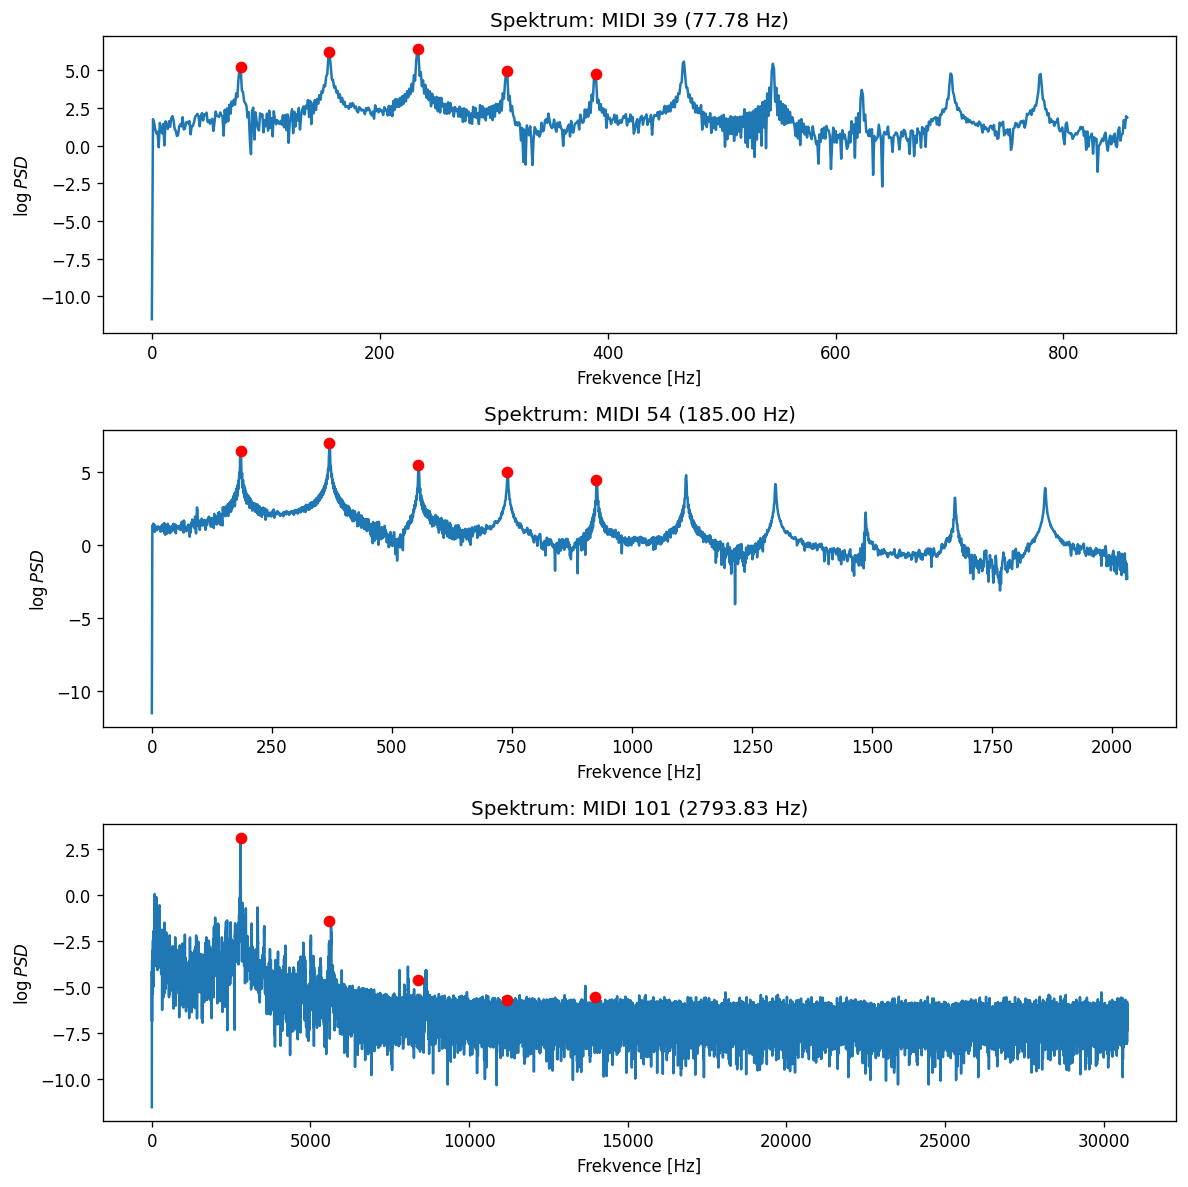

In [13]:
plt.figure(figsize=(10, 10), dpi=120)
for i, (tone, freq) in enumerate(xkucha28t):
    eleven_f0 = int(estimates[tone] * 11)
    dft = np.fft.fft(xall[tone], Fs)
    dft = dft[:eleven_f0]
    plt.subplot(3, 1, i+1)
    plt.plot(np.log(np.abs(dft) + 1e-5))
    plt.title(f"Spektrum: MIDI {tone} ({freq:.2f} Hz)")
    plt.xlabel("Frekvence [Hz]")
    plt.ylabel("$\log PSD$")
    for k in range(0, 5):
        plt.plot((k+1) * estimates[tone], np.log(midi['representation'][tone][k][0]), 'ro')
plt.tight_layout()


# Syntéza tónů

Pro syntézu tónů z reprezentace klavíru jsem použil prosté sčítání cosinusovek. K synchronizování původního a vygenerovaného signálu jsem použil korelaci. Pomocí 5 cosinusovek samozřejmě není možné rekonstruovat všechny zákmity, přesto se vygenerovaný signál se docela pěkně podobá tomu originálnímu. Původní tóny také mírně mění s časem amplitudu a DC offset, což také s touto reprezetací není možné rekonstruovat... V tomto kroku také ukládám syntetizované signály.

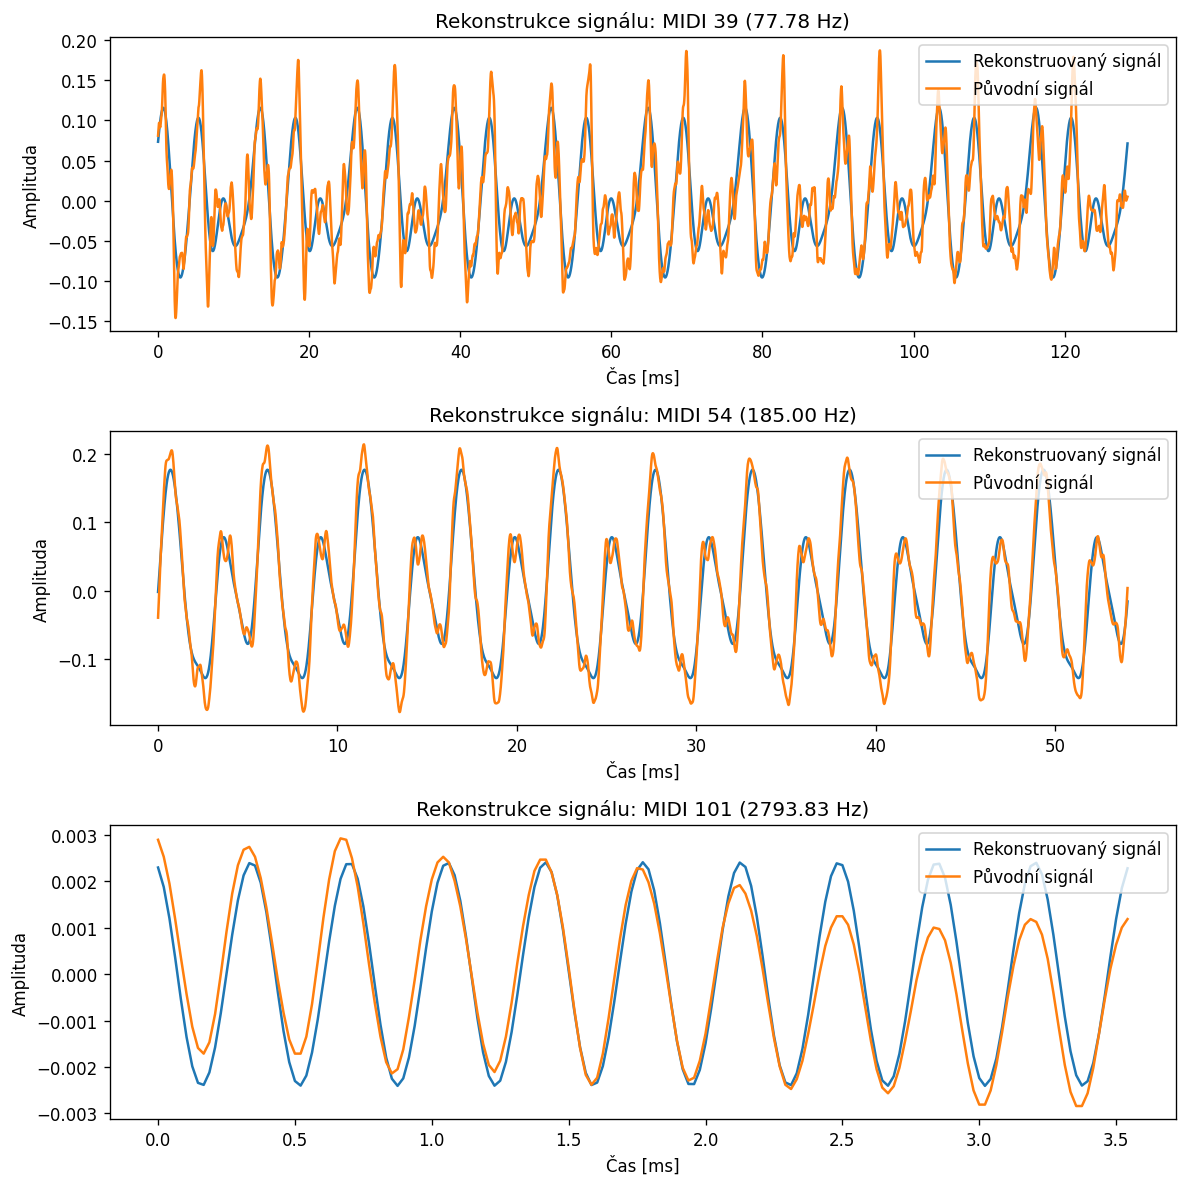

In [14]:
names = ['a', 'b', 'c']
n = np.arange(0, Fs)
plt.figure(figsize=(10, 10), dpi=120)
for i, (tone, freq) in enumerate(xkucha28t):
    # Generate the signal
    res = np.zeros(Fs)
    repre = midi['representation'][tone]
    est = estimates[tone]
    for k in range(0, 5):
        amp = 5 * (repre[k][0] / (Fs))
        cos = np.cos(2 * np.pi * (k+1) * est / Fs * n + repre[k][1])
        res = np.add(res, amp * cos)
    ten_periods = int(Fs / est * 10)
    plot_y = 1000 * np.arange(0, ten_periods) / Fs
    # Calculate offset using correlation
    corr = sig.correlate(xall[tone][:ten_periods], res[:ten_periods])
    corr = corr[len(corr)//2:]
    offset = np.argmax(corr)
    # Plot first 10 periods of original and reconstructed signal
    plt.subplot(3, 1, i+1)
    plt.plot(plot_y, res[:ten_periods])
    plt.plot(plot_y, xall[tone][offset:ten_periods+offset])
    plt.title(f"Rekonstrukce signálu: MIDI {tone} ({freq:.2f} Hz)")
    plt.ylabel("Amplituda")
    plt.xlabel("Čas [ms]")
    plt.legend(['Rekonstruovaný signál', 'Původní signál'])
    # Save the signal
    sf.write(f'../audio/{names[i]}.wav', res, Fs)
plt.tight_layout()

# Generování hudby
Pomocí knihovny Pandas načtu `skladba.txt`. U vzorkovací frekvence 8kHz kontroluji, zda tón neporušuje vzorkovací teorém. Na konci provádím normalizaci hlasitosti.

In [15]:
song = pd.read_csv(open('skladba.txt', 'r'), sep=' ',
                       header=None, names=['from', 'to', 'midi', 'volume'])
def gen_song(length, sampling_freq):
    generated = np.zeros(sampling_freq * length)
    for i, line in song.iterrows():
        l = int(sampling_freq * (line['to'] - line['from']) / 1000)
        n = np.arange(0, l)
        res = np.zeros(l)
        tone = int(line['midi'])
        repre = midi['representation'][tone]
        est = estimates[tone]
        for k in range(0, 5):
            # Break if the frequency is too high
            if (k * est > sampling_freq / 2):
                break
            res = np.add(res, 5 * (repre[k][0] / (sampling_freq)) *
                         np.cos(2 * np.pi * (k+1) * est / sampling_freq * n + repre[k][1]))
        res *=  line['volume'] / 100
        start_pad = int(sampling_freq * line['from'] / 1000)
        end_pad = length - int(sampling_freq * line['to'] / 1000)
        if (end_pad < 0):
            end_pad = sampling_freq * length
        res = np.pad(res, (start_pad, end_pad), 'constant', constant_values=(0, 0))
        res = res[:len(generated)]
        generated = np.add(generated, res)
    max = np.max(np.abs(generated))
    return generated / max

length = 10
song_48k = gen_song(length, 48000)
song_8k = gen_song(length, 8000)
sf.write(f'../audio/out_48k.wav', song_48k, 48000)
sf.write(f'../audio/out_8k.wav', song_8k, 8000)

# Spektogram
Ze spektrogramu jdou pěkně vidět základní i harmonické frekvence jednotlivých tónů. Obzvlášť dobře to lze vidět u histogramu při vzorkovací frekvenci 8kHz. Jdou vidět rychlé změny amplitudy na hranách mezi tóny (vertikální čáry). Toto řeším v bonusu, který následuje.

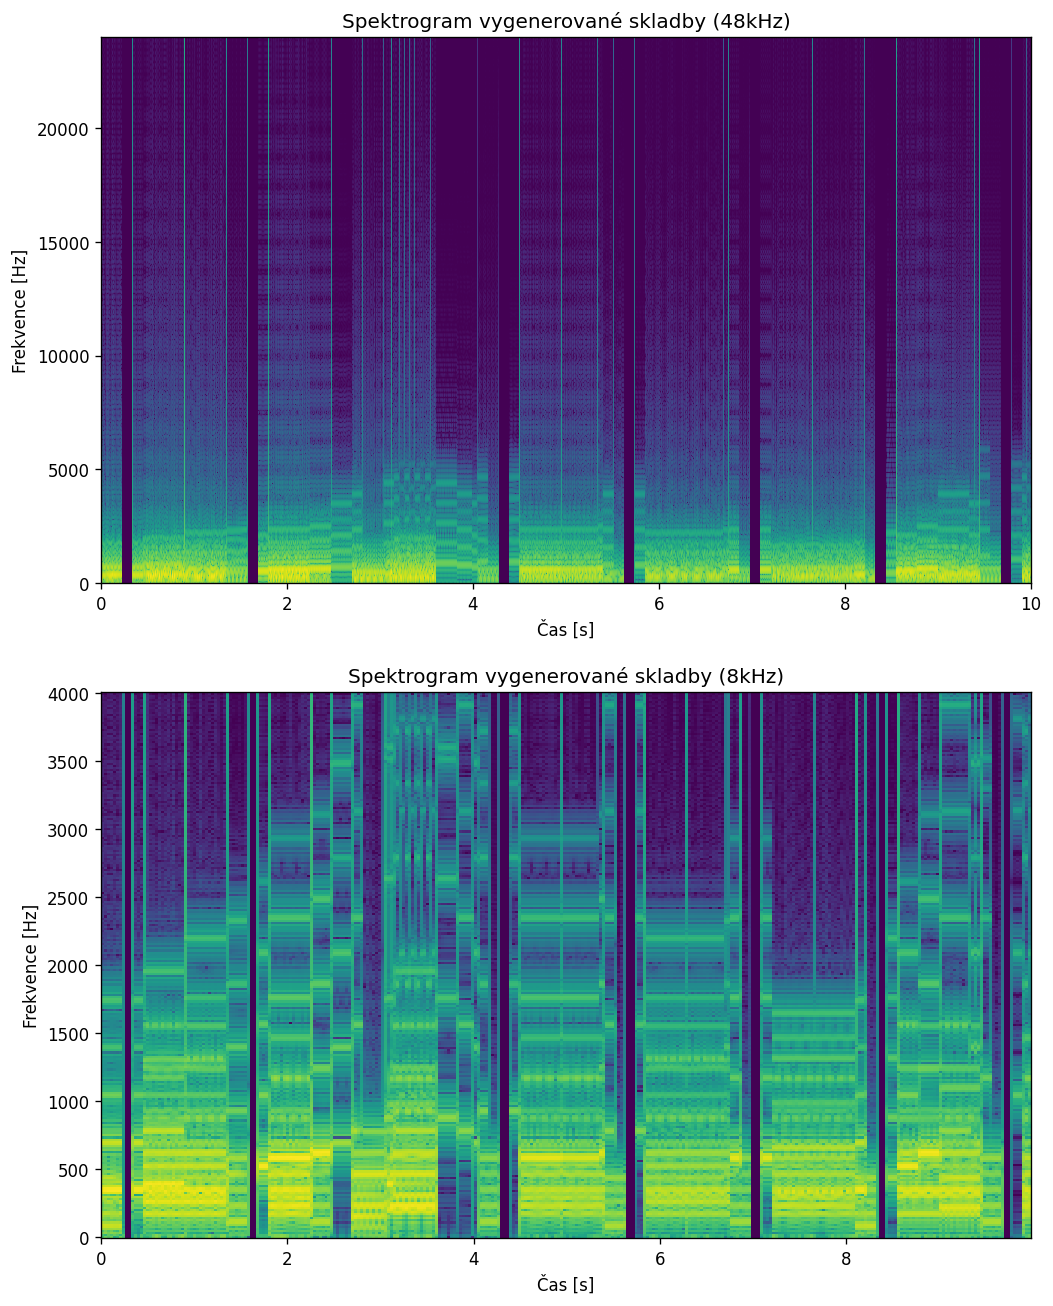

In [16]:
from scipy.signal import spectrogram
plt.figure(figsize=(10, 13), dpi=120)
f, t, sgr = spectrogram(song_48k, 48000, window=(
    'tukey', 0.3), nfft=2048, noverlap=0)
sgr_log = 10 * np.log10(sgr+1e-15)
plt.subplot(2, 1, 1)
plt.pcolormesh(t, f, sgr_log)
plt.xlabel('Čas [s]')
plt.ylabel('Frekvence [Hz]')
plt.title('Spektrogram vygenerované skladby (48kHz)')

f, t, sgr = spectrogram(song_8k, 8000, window=('tukey', 0.3), nfft=512, noverlap=0)
sgr_log = 10 * np.log10(sgr+1e-15)
plt.subplot(2, 1, 2)
plt.pcolormesh(t, f, sgr_log)
plt.xlabel('Čas [s]')
plt.ylabel('Frekvence [Hz]')
plt.title('Spektrogram vygenerované skladby (8kHz)')
plt.show()


# Bonus
Pro vylepšení zvuku jsem použil navrhovanou ADSR obálku. Pro každý tón se vygeneruje vlastní obálka. Části attack, decay, sustain trvají procentuálně podle délky tóny (10%, 30%, 60%). Část release je dál "napevno" navíc 0.2s. Amplitudy jsem fází jsem zvolil 100% a 60%. K těmto číslům jsem došel experimentálně, chtěl jsem aby byla dobrá rovnováha mezi zvukem úderu a celkovou čistotou skladby.

In [17]:
bonus = np.zeros(Fs * 10)
# Params in percent
attack = 0.1
decay = 0.3
sustain = 0.6
# Release is in seconds
release = 0.2
# Percent of original amplitude
attack_amp = 1
sustain_amp = 0.6
for i, line in song.iterrows():
    org_l = int(Fs * (line['to'] - line['from']) / 1000)
    l = org_l + int(Fs * release)
    n = np.arange(0, l)
    res = np.zeros(l)
    tone = int(line['midi'])
    repre = midi['representation'][tone]
    est = estimates[tone]
    for k in range(0, 5):
        res = np.add(res, 5 * (repre[k][0] / (Fs)) *
                     np.cos(2 * np.pi * (k+1) * est / Fs * n + repre[k][1]))
    res *= line['volume'] / 100
    # ADSR envelope
    adsr = np.concatenate([
        np.linspace(0, attack_amp, int(attack * org_l)),
        np.linspace(attack_amp, sustain_amp, int(decay * org_l)),
        np.linspace(sustain_amp, sustain_amp, int(sustain * org_l)),
        np.linspace(sustain_amp, 0, int(Fs * release)),
        np.zeros(10)  # Padding due to integer rounding
    ])
    res = np.multiply(res, adsr[:len(res)])
    start_pad = int(Fs * line['from'] / 1000)
    end_pad = length - int(Fs * line['to'] / 1000)
    if (end_pad < 0):
        end_pad = len(bonus)
    res = np.pad(res, (start_pad, end_pad), 'constant', constant_values=(0, 0))
    res = res[:len(bonus)]
    bonus = np.add(bonus, res)
max = np.max(np.abs(bonus))
sf.write(f'../audio/bonus.wav', bonus / max, Fs)